<a href="https://colab.research.google.com/github/IshwaryaKeerthivasan/Diagnosis-and-Procedure-Pairing/blob/main/Diagnosis_and_Procedure_pairing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the datasets (replace with actual file paths)
d_icd_diagnosis = pd.read_csv("/content/d_icd_diagnoses.csv")
d_icd_procedures = pd.read_csv("/content/d_icd_procedures.csv")

# Sample the datasets to reduce size for computation efficiency
sample_size_diagnosis = 2000  # Adjust this size based on your system's capacity
sample_size_procedures = 2000  # Adjust this size based on your system's capacity

d_icd_diagnosis_sample = d_icd_diagnosis.sample(sample_size_diagnosis, random_state=42)
d_icd_procedures_sample = d_icd_procedures.sample(sample_size_procedures, random_state=42)

# Combine the sampled long_title columns for both diagnoses and procedures
all_long_titles = pd.concat([d_icd_diagnosis_sample['long_title'], d_icd_procedures_sample['long_title']]).reset_index(drop=True)

# Vectorize the text data using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # Added stop_words and limit features for efficiency
tfidf_matrix = vectorizer.fit_transform(all_long_titles)

# Split the matrix back into diagnosis and procedure parts
diagnosis_matrix = tfidf_matrix[:len(d_icd_diagnosis_sample)]
procedure_matrix = tfidf_matrix[len(d_icd_diagnosis_sample):]

# Compute pairwise cosine similarity between diagnoses and procedures
similarity_matrix = cosine_similarity(diagnosis_matrix, procedure_matrix)

# Find the most similar procedure for each diagnosis by picking the procedure with the highest similarity score
most_similar_indices = similarity_matrix.argmax(axis=1)  # Indexes of the most similar procedure for each diagnosis
similarity_scores = similarity_matrix.max(axis=1)  # Corresponding similarity scores

# Create a new column in the diagnosis dataframe to map the most similar procedure
d_icd_diagnosis_sample['most_similar_procedure'] = d_icd_procedures_sample.iloc[most_similar_indices]['long_title'].values
d_icd_diagnosis_sample['similarity_score'] = similarity_scores

# Save the result to a CSV file
d_icd_diagnosis_sample.to_csv("sample_diagnosis_to_procedure_mapping.csv", index=False)

# Print the result
print("Mapping completed for the sample! Results saved to 'sample_diagnosis_to_procedure_mapping.csv'")

Mapping completed for the sample! Results saved to 'sample_diagnosis_to_procedure_mapping.csv'


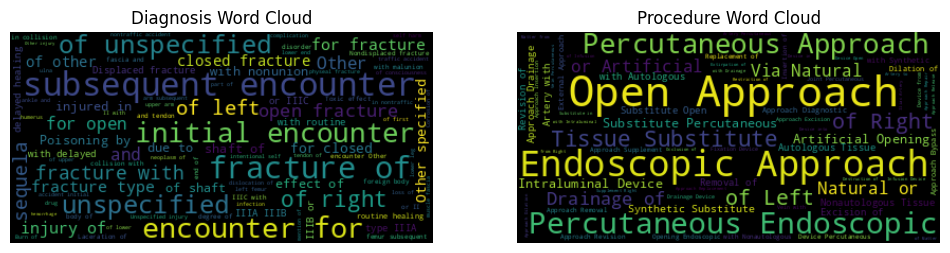

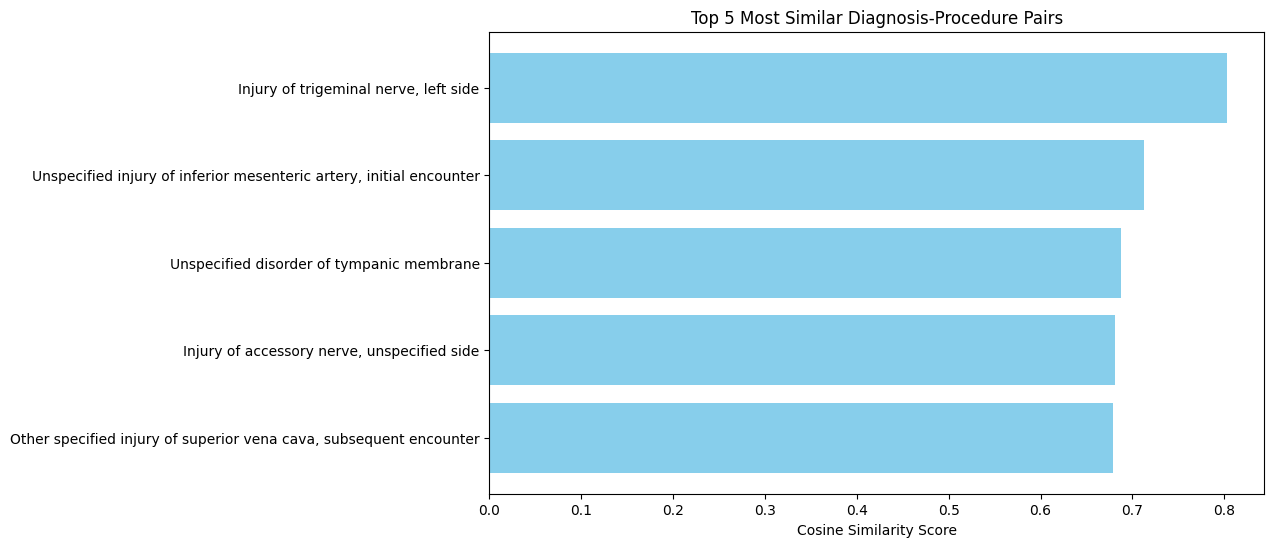

In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import numpy as np

# 1. Word Clouds for Diagnosis and Procedure Descriptions
diagnosis_text = " ".join(d_icd_diagnosis_sample['long_title'])
procedure_text = " ".join(d_icd_procedures_sample['long_title'])

# Create word clouds
wordcloud_diagnosis = WordCloud(stopwords='english', max_words=100).generate(diagnosis_text)
wordcloud_procedure = WordCloud(stopwords='english', max_words=100).generate(procedure_text)

# Plot the word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_diagnosis, interpolation='bilinear')
plt.title("Diagnosis Word Cloud")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_procedure, interpolation='bilinear')
plt.title("Procedure Word Cloud")
plt.axis("off")

plt.show()

# 3. Get the indices of the top 5 most similar pairs
top_5_indices = np.argsort(similarity_scores)[-5:]

# Get the corresponding diagnoses and procedures for the top 5 pairs
top_diagnoses = d_icd_diagnosis_sample.iloc[top_5_indices]['long_title']
top_procedures = d_icd_diagnosis_sample.iloc[top_5_indices]['most_similar_procedure']
top_similarities = similarity_scores[top_5_indices]

# Plot the results
plt.figure(figsize=(10, 6))
plt.barh(top_diagnoses, top_similarities, color='skyblue')
plt.xlabel('Cosine Similarity Score')
plt.title('Top 5 Most Similar Diagnosis-Procedure Pairs')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras import optimizers
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
# Load the dataset
df = pd.read_csv("sample_diagnosis_to_procedure_mapping.csv")

# Vectorize the long_title using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix_diagnosis = vectorizer.fit_transform(df['long_title'])

# You already have similarity scores in the dataset
labels = df['similarity_score'].values

# Train-test split
train_pairs, val_pairs, train_labels, val_labels = train_test_split(tfidf_matrix_diagnosis, labels, test_size=0.2, random_state=42)

from tensorflow.keras import regularizers

def create_siamese_model(input_dim, embedding_dim=128):
    input_layer = layers.Input(shape=(input_dim,))
    dense1 = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
    dropout1 = layers.Dropout(0.7)(dense1)
    dense2 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)
    dense3 = layers.Dense(embedding_dim, activation='relu')(dropout2)
    model = Model(inputs=input_layer, outputs=dense3)
    return model


# Define inputs for diagnosis and procedure
diagnosis_input = layers.Input(shape=(train_pairs.shape[1],))
procedure_input = layers.Input(shape=(train_pairs.shape[1],))

# Create the shared model
shared_model = create_siamese_model(train_pairs.shape[1])

# Encode both the diagnosis and procedure
encoded_diagnosis = shared_model(diagnosis_input)
encoded_procedure = shared_model(procedure_input)

# Compute the cosine similarity between the two encodings
similarity = layers.Dot(axes=-1, normalize=True)([encoded_diagnosis, encoded_procedure])

# Define the model
siamese_model = Model(inputs=[diagnosis_input, procedure_input], outputs=similarity)

# Compile the model
optimizer = optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-5)
siamese_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = siamese_model.fit(
    [train_pairs, train_pairs],  # Train with diagnosis-procedure pairs
    train_labels,
    epochs=40,
    batch_size=64,
    validation_data=([val_pairs, val_pairs], val_labels),
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_mae = siamese_model.evaluate([val_pairs, val_pairs], val_labels)
print(f"Validation Loss: {val_loss}")
print(f"Validation MAE: {val_mae}")

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.1929 - mae: 0.2642 - val_loss: 6.2035 - val_mae: 0.7605
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.5144 - mae: 0.2118 - val_loss: 5.6153 - val_mae: 0.7605
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.9273 - mae: 0.1789 - val_loss: 5.0956 - val_mae: 0.7605
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.4187 - mae: 0.1688 - val_loss: 4.6352 - val_mae: 0.7605
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.9620 - mae: 0.1454 - val_loss: 4.2264 - val_mae: 0.7605
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 3.5646 - mae: 0.1498 - val_loss: 3.8631 - val_mae: 0.7605
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 3.2089 - mae: 0.1452 - val_loss: 3.5405 - val_mae: 0.7605
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 2.8963 - mae: 0.1440 - val_loss: 3.2539 - val_mae: 0.7605
Epoch 9/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 2.616

In [ ]:
import numpy as np

# Select 5 random test samples from the validation set (val_pairs)
random_indices = np.random.choice(val_pairs.shape[0], size=5, replace=False)

# Get the corresponding pairs and labels
test_samples = [val_pairs[i].toarray().flatten() for i in random_indices]  # Convert to dense array and flatten it
true_labels = [val_labels[i] for i in random_indices]

# Convert test samples to the required format (same as training)
test_diagnosis_pairs = np.array(test_samples)  # Ensure it's a 2D array (num_samples, num_features)
test_procedure_pairs = np.array(test_samples)  # The same because we're using the same pair for diagnosis and procedure

# Make predictions using the model
predictions = siamese_model.predict([test_diagnosis_pairs, test_procedure_pairs])

# Print the predicted and true similarity scores for the 5 test samples
for i in range(5):
    print(f"Test Sample {i+1}:")
    print(f"Predicted Similarity Score: {predictions[i][0]}")
    print(f"True Similarity Score: {true_labels[i]}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Test Sample 1:
Predicted Similarity Score: 0.0
True Similarity Score: 0.0
--------------------------------------------------
Test Sample 2:
Predicted Similarity Score: 0.0
True Similarity Score: 0.0
--------------------------------------------------
Test Sample 3:
Predicted Similarity Score: 0.0
True Similarity Score: 0.0
--------------------------------------------------
Test Sample 4:
Predicted Similarity Score: 0.9999998807907104
True Similarity Score: 0.4874096660797303
--------------------------------------------------
Test Sample 5:
Predicted Similarity Score: 0.0
True Similarity Score: 0.4742258981765136
--------------------------------------------------
